# Kaggleで磨く 機械学習の実践力
# 第5章 特徴量エンジニアリング

# 5.1 特徴量エンジニアリングの進め方
#### スクリプト: ライブラリのインポート (スクリプト4-1の再掲)

In [1]:
# 2022/06/02追加: Kaggle notebook環境変更のため
!pip install pandas_profiling==3.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
  Attempting uninstall: visions
    Found existing installation: visions 0.7.5
    Uninstalling visions-0.7.5:
      Successfully uninstalled visions-0.7.5
  Attempting uninstall: pandas_profiling
    Found existing installation: pandas-profiling 2.4.0
    Uninstalling pandas-profiling-2.4.0:
      Successfully uninstalled pandas-profiling-2.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.


In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認
import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=ba6ea716f3097e6c491fe66a8a78d5869179f03fbd2dc2ccb5a0f01bc3da5a98
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


#### スクリプト: ファイルの読み込み (スクリプト4-2の再掲)

In [3]:
df_train = pd.read_csv("../input/titanic/train.csv")

#### スクリプト: データセット作成 (スクリプト4-8の再掲)

In [4]:
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], \
                             df_train[["Survived"]], \
                             df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


#### スクリプト5-1: モデル学習・評価 (スクリプト4-15を関数化)

In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}    

def train_cv(input_x,
             input_y,
             input_id,
             params,
             n_splits=5,
            ):
    metrics = []
    imp = pd.DataFrame()

    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))
    for nfold in np.arange(n_splits):
        print("-"*20, nfold, "-"*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
            input_y["Survived"].mean(),
            y_tr["Survived"].mean(),
            y_va["Survived"].mean(),
        ))

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr), (x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                 )

        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)
        print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))    
        metrics.append([nfold, metric_tr, metric_va])

        _imp = pd.DataFrame({"col":input_x.columns, "imp":model.feature_importances_, "nfold":nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print("-"*20, "result", "-"*20)
    metrics = np.array(metrics)
    print(metrics)

    print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std(),
    ))

    imp = imp.groupby("col")["imp"].agg(["mean", "std"])
    imp.columns = ["imp", "imp_std"]
    imp = imp.reset_index(drop=False)

    print("Done.")
    
    return imp, metrics

#### スクリプト5-2: モデル学習・評価

In [6]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.826717	valid_1's auc: 0.753008
[accuracy] tr: 0.75, va: 0.68
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.839483	valid_1's auc: 0.732687
[200]	training's auc: 0.849542	valid_1's auc: 0.737233
[accuracy] tr: 0.77, va: 0.69
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.831826	valid_1's auc: 0.752941
[accuracy] tr: 0.75, va: 0.69
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388
[100]	training'

#### スクリプト5-3: 変数追加・データセット作成（Ageの追加）

In [7]:
x_train, y_train, id_train = df_train[["Pclass", "Fare", "Age"]], \
                             df_train[["Survived"]], \
                             df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 3) (891, 1) (891, 1)


#### スクリプト5-4: モデル学習・評価（新しいデータセットの利用）

In [8]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 3) (712, 1)
(179, 3) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[100]	training's auc: 0.931588	valid_1's auc: 0.721937
[accuracy] tr: 0.82, va: 0.70
-------------------- 1 --------------------
(713, 3) (713, 1)
(178, 3) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.927165	valid_1's auc: 0.736096
[accuracy] tr: 0.76, va: 0.72
-------------------- 2 --------------------
(713, 3) (713, 1)
(178, 3) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.923299	valid_1's auc: 0.75488
[accuracy] tr: 0.70, va: 0.66
-------------------- 3 --------------------
(713, 3) (713, 1)
(178, 3) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.923524	valid_1's auc: 0.730348
[accuracy] tr: 0.77, va: 0.67
-------------------- 4 --------------------
(713, 3) (713, 1)
(178, 3) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388
[100]	training's auc: 0.927564	valid_1's auc: 0.746177
[accuracy] tr: 0

#### スクリプト5-5: 説明変数の重要度の算出

In [9]:
imp.sort_values("imp", ascending=False, ignore_index=True)

col         imp     imp_std
0    Fare  547.621958  270.958097
1     Age  436.497719  247.807858
2  Pclass  299.843845  103.344422

# 5.2 データ前処理

## 5.2.1 データの確認（詳細）
#### スクリプト5-6: 要約統計量の一括確認 (数値データ)

In [10]:
df_train.describe().T

count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

#### スクリプト5-7: 要約統計量の一括確認（カテゴリ変数）

In [11]:
df_train.describe(exclude='number').T

count unique                      top freq
Name       891    891  Braund, Mr. Owen Harris    1
Sex        891      2                     male  577
Ticket     891    681                   347082    7
Cabin      204    147                  B96 B98    4
Embarked   889      3                        S  644

#### 要約統計量の一括確認（両方まとめて）

In [12]:
# df_train.describe(include='all').T

#### スクリプト5-8: 要約統計量の確認 (数値データ)

In [13]:
df_train[["Fare"]].agg(["mean"]).T

mean
Fare  32.204208

#### スクリプト5-9 複数の要約統計量の確認（その1）

In [14]:
df_train[["Fare"]].agg(["mean", "std", "min", "max"]).T

mean        std  min       max
Fare  32.204208  49.693429  0.0  512.3292

#### スクリプト5-10: 複数の要約統計量の確認（その2）

In [15]:
df_train[["Fare"]].agg(["dtype", "count", "nunique", "mean", "std", "min", "max"]).T

dtype count nunique       mean        std  min       max
Fare  float64   891     248  32.204208  49.693429  0.0  512.3292

#### スクリプト5-11: 複数のカラムを同時に確認

In [16]:
df_train.agg(["dtype", "count", "nunique", "min", "mean", "max"]).T

dtype count nunique                  min       mean  \
PassengerId    int64   891     891                    1      446.0   
Survived       int64   891       2                    0   0.383838   
Pclass         int64   891       3                    1   2.308642   
Name          object   891     891  Abbing, Mr. Anthony        NaN   
Sex           object   891       2               female        NaN   
Age          float64   714      88                 0.42  29.699118   
SibSp          int64   891       7                    0   0.523008   
Parch          int64   891       7                    0   0.381594   
Ticket        object   891     681               110152        NaN   
Fare         float64   891     248                  0.0  32.204208   
Cabin         object   204     147                  NaN        NaN   
Embarked      object   889       3                  NaN        NaN   

                                     max  
PassengerId                          891  
Survived                               1  
Pclass                                 3  
Name         van Melkebeke, Mr. Philemon  
Sex                                 male  
Age                                 80.0  
SibSp                                  8  
Parch                                  6  
Ticket                         WE/P 5735  
Fare                            512.3292  
Cabin                                NaN  
Embarked                             NaN

#### スクリプト5-12: 種類ごとの件数確認

In [17]:
df_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

#### スクリプト5-13: pandas_profilingライブラリの利用

In [18]:
pdp.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 5.2.2 欠損値の把握・補間
#### スクリプト5-14: 欠損値の確認

In [19]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### スクリプト5-15: 欠損値補間（0埋め）

In [20]:
df_train["Age_fillna_0"] = df_train["Age"].fillna(0)
df_train.loc[df_train["Age"].isnull(), ["Age", "Age_fillna_0"]].head()

Age  Age_fillna_0
5   NaN           0.0
17  NaN           0.0
19  NaN           0.0
26  NaN           0.0
28  NaN           0.0

#### スクリプト5-16: 欠損値補間（平均値補間）

In [21]:
df_train["Age_fillna_mean"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train.loc[df_train["Age"].isnull(), ["Age", "Age_fillna_mean"]].head()

Age  Age_fillna_mean
5   NaN        29.699118
17  NaN        29.699118
19  NaN        29.699118
26  NaN        29.699118
28  NaN        29.699118

#### スクリプト5-17: 欠損値補間（空白埋め）

In [22]:
df_train["Cabin_fillna_space"] = df_train["Cabin"].fillna("")
df_train.loc[df_train["Cabin"].isnull(), ["Cabin", "Cabin_fillna_space"]].head()

Cabin Cabin_fillna_space
0   NaN                   
2   NaN                   
4   NaN                   
5   NaN                   
7   NaN

#### スクリプト5-18: 欠損値補間（最頻値補間）

In [23]:
df_train["Cabin_fillna_mode"] = df_train["Cabin"].fillna(df_train["Cabin"].mode()[0])
df_train.loc[df_train["Cabin"].isnull(), ["Cabin", "Cabin_fillna_mode"]].head()

Cabin Cabin_fillna_mode
0   NaN           B96 B98
2   NaN           B96 B98
4   NaN           B96 B98
5   NaN           B96 B98
7   NaN           B96 B98

## 5.2.3 外れ値の検出・補正
#### スクリプト5-19: 最小値と最大値の確認

In [24]:
df_train["Age"].agg(["min","max"])

min     0.42
max    80.00
Name: Age, dtype: float64

#### スクリプト5-20: 分布の確認

<AxesSubplot:>

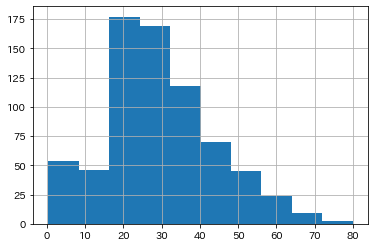

In [25]:
df_train["Age"].hist()

#### スクリプト5-21: 四分位範囲を利用した外れ値検出方法

In [26]:
quartile = df_train["Age"].quantile(q=0.75) - df_train["Age"].quantile(q=0.25)
print("四分位範囲:", quartile)
print("下限値:", df_train["Age"].quantile(q=0.25) - quartile*1.5)
print("上限値:", df_train["Age"].quantile(q=0.75) + quartile*1.5)

四分位範囲: 17.875
下限値: -6.6875
上限値: 64.8125


#### スクリプト5-22: 外れ値を欠損値に変換

In [27]:
df_train.loc[df_train["Age"]<0, "Age"] = np.nan 

## 5.2.4 標準化・正規化
#### スクリプト5-23: 標準化

In [28]:
value_mean = df_train["Fare"].mean()
value_std = df_train["Fare"].std(ddof=0) #母集団の標準偏差を利用する場合
# value_std = df_train["Fare"].std() #標本の標準偏差を利用する場合
print("mean:", value_mean, ", std:", value_std)

df_train["Fare_standard"] = (df_train["Fare"] - value_mean) / value_std
df_train[["Fare", "Fare_standard"]].head()

mean: 32.204207968574636 , std: 49.6655344447741


Fare  Fare_standard
0   7.2500      -0.502445
1  71.2833       0.786845
2   7.9250      -0.488854
3  53.1000       0.420730
4   8.0500      -0.486337

#### スクリプト5-24: 標準化（scikit-learn利用）

In [29]:
std = StandardScaler()
std.fit(df_train[["Fare"]])
print("mean:", std.mean_[0], ", std:", np.sqrt(std.var_[0]))

df_train["Fare_standard"] = std.transform(df_train[["Fare"]])
df_train[["Fare", "Fare_standard"]].head()

mean: 32.204207968574636 , std: 49.6655344447741


Fare  Fare_standard
0   7.2500      -0.502445
1  71.2833       0.786845
2   7.9250      -0.488854
3  53.1000       0.420730
4   8.0500      -0.486337

#### スクリプト5-25: 正規化

In [30]:
value_min = df_train["Fare"].min()
value_max = df_train["Fare"].max()
print("min:", value_min, ", max:", value_max)

df_train["Fare_normalize"] = (df_train["Fare"] - value_min) / (value_max - value_min)
df_train[["Fare", "Fare_normalize"]].head()

min: 0.0 , max: 512.3292


Fare  Fare_normalize
0   7.2500        0.014151
1  71.2833        0.139136
2   7.9250        0.015469
3  53.1000        0.103644
4   8.0500        0.015713

#### スクリプト5-26: 正規化（scikit-learn利用）

In [31]:
mms = MinMaxScaler(feature_range=(0, 1)) #範囲を変更
mms.fit(df_train[["Fare"]])
print("min:", mms.data_min_[0], ", max:", mms.data_max_[0])

df_train["Fare_normalize"] = mms.transform(df_train[["Fare"]])
df_train[["Fare", "Fare_normalize"]].head()

min: 0.0 , max: 512.3292


Fare  Fare_normalize
0   7.2500        0.014151
1  71.2833        0.139136
2   7.9250        0.015469
3  53.1000        0.103644
4   8.0500        0.015713

# 5.3 特徴量生成
## 5.3.1 単変数: 数値
#### スクリプト5-27: 対数変換

In [32]:
df_train["Fare_log"] = np.log(df_train["Fare"] + 1e-5)
df_train[["Fare", "Fare_log"]].head()

Fare  Fare_log
0   7.2500  1.981003
1  71.2833  4.266662
2   7.9250  2.070024
3  53.1000  3.972177
4   8.0500  2.085673

#### スクリプト5-28: 累乗／指数関数／逆数

In [33]:
df_train["Fare_square"] = df_train["Fare"].apply(lambda x: x**2)
df_train["Fare_exp"] = df_train["Fare"].apply(lambda x: np.exp(x))
df_train["Fare_reciprocal"] = df_train["Fare"].apply(lambda x: 1/(x+1e-3))
df_train[["Fare", "Fare_square", "Fare_exp", "Fare_reciprocal"]].head()

Fare  Fare_square      Fare_exp  Fare_reciprocal
0   7.2500    52.562500  1.408105e+03         0.137912
1  71.2833  5081.308859  9.077031e+30         0.014028
2   7.9250    62.805625  2.765564e+03         0.126167
3  53.1000  2819.610000  1.150898e+23         0.018832
4   8.0500    64.802500  3.133795e+03         0.124208

#### スクリプト5-29: 離散化

In [34]:
df_train["Age_bin"] = pd.cut(df_train["Age"], 
                             bins=[0,10,20,30,40,50,100],
                             right=False,
                             labels=["10代未満","10代","20代","30代","40代","50代以上"],
                             duplicates="raise",
                             include_lowest=True,
                            )
df_train["Age_bin"] = df_train["Age_bin"].astype(str)
df_train[["Age", "Age_bin"]].head()

Age Age_bin
0  22.0     20代
1  38.0     30代
2  26.0     20代
3  35.0     30代
4  35.0     30代

#### スクリプト5-30: 欠損かどうかで0/1に変換

In [35]:
df_train["Age_na"] = df_train["Age"].isnull()*1
df_train[["Age", "Age_na"]].head(7)

Age  Age_na
0  22.0       0
1  38.0       0
2  26.0       0
3  35.0       0
4  35.0       0
5   NaN       1
6  54.0       0

## 5.3.2 単変数：カテゴリ変数
#### スクリプト5-31: one-hot-encoding

In [36]:
ohe_embarked = OneHotEncoder(sparse=False)
ohe_embarked.fit(df_train[["Embarked"]])

tmp_embarked = pd.DataFrame(
    ohe_embarked.transform(df_train[["Embarked"]]), 
    columns=["Embarked_{}".format(i) for i in ohe_embarked.categories_[0]],
)

df_train = pd.concat([df_train, tmp_embarked], axis=1)
df_train[["Embarked", "Embarked_C", "Embarked_Q", "Embarked_S", "Embarked_nan"]].head()

Embarked  Embarked_C  Embarked_Q  Embarked_S  Embarked_nan
0        S         0.0         0.0         1.0           0.0
1        C         1.0         0.0         0.0           0.0
2        S         0.0         0.0         1.0           0.0
3        S         0.0         0.0         1.0           0.0
4        S         0.0         0.0         1.0           0.0

#### スクリプト5-32: one-hot-encoding（一括変換）

In [37]:
df_ohe = pd.get_dummies(df_train[["Embarked", "Sex"]], dummy_na=True, drop_first=False)
df_ohe.head()

Embarked_C  Embarked_Q  Embarked_S  Embarked_nan  Sex_female  Sex_male  \
0           0           0           1             0           0         1   
1           1           0           0             0           1         0   
2           0           0           1             0           1         0   
3           0           0           1             0           1         0   
4           0           0           1             0           0         1   

   Sex_nan  
0        0  
1        0  
2        0  
3        0  
4        0

#### スクリプト5-33: count-encoding

In [38]:
ce_Embarked = df_train["Embarked"].value_counts().to_dict()
print(ce_Embarked)
df_train["Embarked_ce"] = df_train["Embarked"].map(ce_Embarked)
df_train[["Embarked", "Embarked_ce"]].head()

{'S': 644, 'C': 168, 'Q': 77}


Embarked  Embarked_ce
0        S        644.0
1        C        168.0
2        S        644.0
3        S        644.0
4        S        644.0

#### スクリプト5-34: label-encoding

In [39]:
le_embarked = LabelEncoder()
le_embarked.fit(df_train["Embarked"])
df_train["Embarked_le"] = le_embarked.transform(df_train["Embarked"])
df_train[["Embarked", "Embarked_le"]].head(5)

Embarked  Embarked_le
0        S            2
1        C            0
2        S            2
3        S            2
4        S            2

#### スクリプト5-35: 欠損かどうかで0/1に変換

In [40]:
df_train["Embarked_na"] = df_train["Embarked"].isnull()*1
df_train.loc[df_train["Embarked"].isnull(), ["Embarked", "Embarked_na"]].head(5)

Embarked  Embarked_na
61       NaN            1
829      NaN            1

## 5.3.3 2変数組合せ: 数値x数値
#### スクリプト5-36: 数値x数値

In [41]:
df_train["SibSp_+_Parch"] = df_train["SibSp"] + df_train["Parch"]
df_train[["SibSp", "Parch", "SibSp_+_Parch"]].head()

SibSp  Parch  SibSp_+_Parch
0      1      0              1
1      1      0              1
2      0      0              0
3      1      0              1
4      0      0              0

## 5.3.4 2変数組合せ: 数値xカテゴリ変数
#### スクリプト5-37: 数値xカテゴリ変数（例1）

In [42]:
df_agg = df_train.groupby("Sex")["Fare"].agg(["mean"]).reset_index()
df_agg.columns = ["Sex", "mean_Fare_by_Sex"]
print("集約テーブル")
display(df_agg)

df_train = pd.merge(df_train, df_agg, on="Sex", how="left")
print("結合後テーブル")
display(df_train[["Sex", "Fare", "mean_Fare_by_Sex"]].head())

集約テーブル


Sex  mean_Fare_by_Sex
0  female         44.479818
1    male         25.523893

結合後テーブル


Sex     Fare  mean_Fare_by_Sex
0    male   7.2500         25.523893
1  female  71.2833         44.479818
2  female   7.9250         44.479818
3  female  53.1000         44.479818
4    male   8.0500         25.523893

#### スクリプト5-38: 数値xカテゴリ変数（例2）

In [43]:
df_train["mean_Fare_by_Sex"] = df_train.groupby("Sex")["Fare"].transform("mean")
df_train[["Sex", "Fare", "mean_Fare_by_Sex"]].head()

Sex     Fare  mean_Fare_by_Sex
0    male   7.2500         25.523893
1  female  71.2833         44.479818
2  female   7.9250         44.479818
3  female  53.1000         44.479818
4    male   8.0500         25.523893

## 5.3.5 2変数組合せ: カテゴリ変数xカテゴリ変数
#### スクリプト5-39: ①カテゴリ変数xカテゴリ変数：出現回数（例1）

In [44]:
df_tbl = pd.crosstab(df_train["Sex"], df_train["Embarked"])
print("集約テーブル（クロス集計）")
display(df_tbl)

df_tbl = df_tbl.reset_index()
df_tbl = pd.melt(df_tbl, id_vars="Sex", value_name="count_Sex_x_Embarked")
print("集約テーブル（縦持ち変換後）")
display(df_tbl)

df_train = pd.merge(df_train, df_tbl, on=["Sex", "Embarked"], how="left")
print("結合後テーブル")
df_train[["Sex", "Embarked", "count_Sex_x_Embarked"]].head()

集約テーブル（クロス集計）


Embarked   C   Q    S
Sex                  
female    73  36  203
male      95  41  441

集約テーブル（縦持ち変換後）


Sex Embarked  count_Sex_x_Embarked
0  female        C                    73
1    male        C                    95
2  female        Q                    36
3    male        Q                    41
4  female        S                   203
5    male        S                   441

結合後テーブル


Sex Embarked  count_Sex_x_Embarked
0    male        S                 441.0
1  female        C                  73.0
2  female        S                 203.0
3  female        S                 203.0
4    male        S                 441.0

#### スクリプト5-40: ①カテゴリ変数xカテゴリ変数：出現回数（例2）

In [45]:
df_train["count_Sex_x_Embarked"] = df_train.groupby(["Sex", "Embarked"])["PassengerId"].transform("count")
df_train[["Sex", "Embarked", "count_Sex_x_Embarked"]].head()

Sex Embarked  count_Sex_x_Embarked
0    male        S                 441.0
1  female        C                  73.0
2  female        S                 203.0
3  female        S                 203.0
4    male        S                 441.0

#### スクリプト5-41: ②カテゴリ変数xカテゴリ変数：出現割合

In [46]:
df_tbl = pd.crosstab(df_train["Sex"], df_train["Embarked"], normalize="index")
print("集約テーブル（行方向の和で割る）")
display(df_tbl)

df_tbl = df_tbl.reset_index()
df_tbl = pd.melt(df_tbl, id_vars="Sex", value_name="rate_Sex_x_Embarked")
print("集約テーブル（縦持ち変換後）")
display(df_tbl)

df_train = pd.merge(df_train, df_tbl, on=["Sex", "Embarked"], how="left")
print("結合後テーブル")
df_train[["Sex", "Embarked", "rate_Sex_x_Embarked"]].head()

集約テーブル（行方向の和で割る）


Embarked         C         Q         S
Sex                                   
female    0.233974  0.115385  0.650641
male      0.164645  0.071057  0.764298

集約テーブル（縦持ち変換後）


Sex Embarked  rate_Sex_x_Embarked
0  female        C             0.233974
1    male        C             0.164645
2  female        Q             0.115385
3    male        Q             0.071057
4  female        S             0.650641
5    male        S             0.764298

結合後テーブル


Sex Embarked  rate_Sex_x_Embarked
0    male        S             0.764298
1  female        C             0.233974
2  female        S             0.650641
3  female        S             0.650641
4    male        S             0.764298

#### スクリプト5-42: ③カテゴリ変数xカテゴリ変数：条件式を用いた変換

In [47]:
df_train["Sex=male_&_Embarked=S"] = np.where((df_train["Sex"]=="male") & (df_train["Embarked"]=="S"), 1, 0)
df_train[["Sex", "Embarked", "Sex=male_&_Embarked=S"]].head()

Sex Embarked  Sex=male_&_Embarked=S
0    male        S                      1
1  female        C                      0
2  female        S                      0
3  female        S                      0
4    male        S                      1

## 5.3.6 時系列データ
#### スクリプト5-43: ラグ特徴量（1行シフト）

In [48]:
df1 = pd.DataFrame({"date":pd.date_range("2021-01-01","2021-01-10"),
                    "weather":["晴れ","晴れ","雨","くもり","くもり","晴れ","雨","晴れ","晴れ","晴れ"],
                   })

df1["weathre_shift1"] = df1["weather"].shift(1)
df1

date weather weathre_shift1
0 2021-01-01      晴れ            NaN
1 2021-01-02      晴れ             晴れ
2 2021-01-03       雨             晴れ
3 2021-01-04     くもり              雨
4 2021-01-05     くもり            くもり
5 2021-01-06      晴れ            くもり
6 2021-01-07       雨             晴れ
7 2021-01-08      晴れ              雨
8 2021-01-09      晴れ             晴れ
9 2021-01-10      晴れ             晴れ

#### スクリプト5-44: ラグ特徴量（1行シフト）: シフトによって生じた欠損値を補間

In [49]:
# 欠損値を前埋めしたい場合
df1["weathre_shift1"] = df1["weathre_shift1"].interpolate(method="bfill")
df1

date weather weathre_shift1
0 2021-01-01      晴れ             晴れ
1 2021-01-02      晴れ             晴れ
2 2021-01-03       雨             晴れ
3 2021-01-04     くもり              雨
4 2021-01-05     くもり            くもり
5 2021-01-06      晴れ            くもり
6 2021-01-07       雨             晴れ
7 2021-01-08      晴れ              雨
8 2021-01-09      晴れ             晴れ
9 2021-01-10      晴れ             晴れ

#### スクリプト5-45: ラグ特徴量（IDごとにシフト）

In [50]:
df2 = pd.DataFrame({"id":["A"]*3 + ["B"]*2 + ["C"]*4,
                    "date":["2021-04-02","2021-04-10","2021-04-25",
                            "2021-04-18","2021-04-19",
                            "2021-04-01","2021-04-04","2021-04-09","2021-04-12",
                           ],
                    "money":[1000,2000,900,4000,1800,900,1200,1100,2900],
                   })
df2["date"] = pd.to_datetime(df2["date"], format="%Y-%m-%d")

df2["money_shift1"] = df2.groupby("id")["money"].shift(1)
df2

id       date  money  money_shift1
0  A 2021-04-02   1000           NaN
1  A 2021-04-10   2000        1000.0
2  A 2021-04-25    900        2000.0
3  B 2021-04-18   4000           NaN
4  B 2021-04-19   1800        4000.0
5  C 2021-04-01    900           NaN
6  C 2021-04-04   1200         900.0
7  C 2021-04-09   1100        1200.0
8  C 2021-04-12   2900        1100.0

#### スクリプト5-46: ラグ特徴量（経過日数）

In [51]:
df2["date_shift1"] = df2.groupby("id")["date"].shift(1)
df2["days_elapsed"] = df2["date"] - df2["date_shift1"]
df2["days_elapsed"] = df2["days_elapsed"].dt.days
df2

id       date  money  money_shift1 date_shift1  days_elapsed
0  A 2021-04-02   1000           NaN         NaT           NaN
1  A 2021-04-10   2000        1000.0  2021-04-02           8.0
2  A 2021-04-25    900        2000.0  2021-04-10          15.0
3  B 2021-04-18   4000           NaN         NaT           NaN
4  B 2021-04-19   1800        4000.0  2021-04-18           1.0
5  C 2021-04-01    900           NaN         NaT           NaN
6  C 2021-04-04   1200         900.0  2021-04-01           3.0
7  C 2021-04-09   1100        1200.0  2021-04-04           5.0
8  C 2021-04-12   2900        1100.0  2021-04-09           3.0

#### スクリプト5-47: ウィンドウ特徴量

In [52]:
df3 = pd.DataFrame({"date":pd.date_range("2021-01-01","2021-01-10"),
                    "temperature":[8,10,12,11,9,10,12,7,9,10],
                   })
df3["temperature_window3"] = df3["temperature"].rolling(window=3).mean()
df3

date  temperature  temperature_window3
0 2021-01-01            8                  NaN
1 2021-01-02           10                  NaN
2 2021-01-03           12            10.000000
3 2021-01-04           11            11.000000
4 2021-01-05            9            10.666667
5 2021-01-06           10            10.000000
6 2021-01-07           12            10.333333
7 2021-01-08            7             9.666667
8 2021-01-09            9             9.333333
9 2021-01-10           10             8.666667

#### スクリプト5-48: ウィンドウ特徴量（IDごと）

In [53]:
df4 = pd.DataFrame({"id":["A"]*3 + ["B"]*2 + ["C"]*4,
                    "date":["2021-04-02","2021-04-10","2021-04-25",
                            "2021-04-18","2021-04-19",
                            "2021-04-01","2021-04-04","2021-04-09","2021-04-12",
                           ],
                    "money":[1000,2000,900,4000,1800,900,1200,1100,2900],
                   })
df4["date"] = pd.to_datetime(df4["date"], format="%Y-%m-%d")
df4["money_shift1"] = df4.groupby("id")["money"].apply(lambda x: x.rolling(window=2).mean())
df4

id       date  money  money_shift1
0  A 2021-04-02   1000           NaN
1  A 2021-04-10   2000        1500.0
2  A 2021-04-25    900        1450.0
3  B 2021-04-18   4000           NaN
4  B 2021-04-19   1800        2900.0
5  C 2021-04-01    900           NaN
6  C 2021-04-04   1200        1050.0
7  C 2021-04-09   1100        1150.0
8  C 2021-04-12   2900        2000.0

#### スクリプト5-49: 累積特徴量

In [54]:
df5 = pd.DataFrame({"date":pd.date_range("2021-01-01","2021-01-10"),
                    "flag_rain":[0,0,1,0,0,0,1,0,0,0],
                   })
df5["flag_rain_cumsum"] = df5["flag_rain"].cumsum()
df5

date  flag_rain  flag_rain_cumsum
0 2021-01-01          0                 0
1 2021-01-02          0                 0
2 2021-01-03          1                 1
3 2021-01-04          0                 1
4 2021-01-05          0                 1
5 2021-01-06          0                 1
6 2021-01-07          1                 2
7 2021-01-08          0                 2
8 2021-01-09          0                 2
9 2021-01-10          0                 2

#### スクリプト5-50: 累積特徴量（IDごと）

In [55]:
df6 = pd.DataFrame({"id":["A"]*3 + ["B"]*2 + ["C"]*4,
                    "date":["2021-04-02","2021-04-10","2021-04-25",
                            "2021-04-18","2021-04-19",
                            "2021-04-01","2021-04-04","2021-04-09","2021-04-12",
                           ],
                    "money":[1000,2000,900,4000,1800,900,1200,1100,2900],
                   })
df6["date"] = pd.to_datetime(df6["date"], format="%Y-%m-%d")
df6["money_cumsum"] = df6.groupby("id")["money"].cumsum()
df6

id       date  money  money_cumsum
0  A 2021-04-02   1000          1000
1  A 2021-04-10   2000          3000
2  A 2021-04-25    900          3900
3  B 2021-04-18   4000          4000
4  B 2021-04-19   1800          5800
5  C 2021-04-01    900           900
6  C 2021-04-04   1200          2100
7  C 2021-04-09   1100          3200
8  C 2021-04-12   2900          6100

## 5.3.7 テキストデータ
#### スクリプト5-51: BoWによるベクトル化

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
# vec = CountVectorizer() #全単語を特徴量にする場合
vec = CountVectorizer(min_df=20) #10個しか出現しないレアなワードを除外

vec.fit(df_train["Name"])

df_name = pd.DataFrame(vec.transform(df_train["Name"]).toarray(), columns=vec.get_feature_names())
print(df_name.shape)
df_name.head()

(891, 12)


charles  george  henry  james  john  mary  master  miss  mr  mrs  thomas  \
0        0       0      0      0     0     0       0     0   1    0       0   
1        0       0      0      0     1     0       0     0   0    1       0   
2        0       0      0      0     0     0       0     1   0    0       0   
3        0       0      0      0     0     0       0     0   0    1       0   
4        0       0      1      0     0     0       0     0   1    0       0   

   william  
0        0  
1        0  
2        0  
3        0  
4        1

#### スクリプト5-52: MeCabのKaggle分析環境へのインストールとインポート

In [57]:
!apt-get install -y mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3
os.environ['MECABRC']= "/etc/mecabrc"

import MeCab




The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 16 not upgraded.
Need to get 7373 kB of archives.
After this operation, 60.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libmecab2 amd64 0.996-10build1 [233 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libmecab-dev amd64 0.996-10build1 [285 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 mecab-utils amd64 0.996-10build1 [4912 B]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 mecab-ipadic all 2.7.0-20070801+main-2.1 [6714 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 mecab amd64 0.996-10build1 [132 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal/main amd64 mecab-ipadic-utf8 all 2.7.0-20070801+main-2.1 [4380 B]
Fetched 7373 k

#### スクリプト5-53: BoWによるベクトル化（日本語の場合）

In [58]:
print("サンプルデータ:")
df_text = pd.DataFrame({"text": [
    "今日は雨ですね。天気予報では明日も雨です。",
    "雨なので傘を持って行った方がいいです。",
    "天気予報によると明後日は晴れのようです。",
]})
display(df_text)

print("形態素解析+分かち書き:")
wakati = MeCab.Tagger("-Owakati")
df_text["text_wakati"] = df_text["text"].apply(lambda x: wakati.parse(x).replace("\n",""))
display(df_text)

print("BoWによるベクトル化:")
vec = CountVectorizer()
vec.fit(df_text["text_wakati"])
df_text_vec = pd.DataFrame(vec.transform(df_text["text_wakati"]).toarray(), columns=vec.get_feature_names())
df_text_vec.head()

サンプルデータ:


text
0  今日は雨ですね。天気予報では明日も雨です。
1    雨なので傘を持って行った方がいいです。
2   天気予報によると明後日は晴れのようです。

形態素解析+分かち書き:


text                           text_wakati
0  今日は雨ですね。天気予報では明日も雨です。  今日 は 雨 です ね 。 天気 予報 で は 明日 も 雨 です 。 
1    雨なので傘を持って行った方がいいです。     雨 な ので 傘 を 持っ て 行っ た 方 が いい です 。 
2   天気予報によると明後日は晴れのようです。      天気 予報 に よる と 明後日 は 晴れ の よう です 。

BoWによるベクトル化:


いい  です  ので  よう  よる  予報  今日  天気  持っ  明後日  明日  晴れ  行っ
0   0   2   0   0   0   1   1   1   0    0   1   0   0
1   1   1   1   0   0   0   0   0   1    0   0   0   1
2   0   1   0   1   1   1   0   1   0    1   0   1   0